In [62]:
import sys
sys.path.insert(0, './vONTSS/src/topicmodeling')
from vONTSS.src.topicmodeling.model import TopicModel

sys.path.append("..")
from ris_evaluation.evaluator import Evaluator

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [64]:
documents_df = pd.read_csv('../../datasets/data/BBC_News/documents.csv')
documents_df = documents_df

documents = documents_df['document'].tolist()
labels = documents_df['class_name'].tolist()

labels_df = pd.read_csv('../../datasets/data/BBC_News/labels.csv')
defined_keywords = [keywords.split(' ') for keywords in labels_df['class_keywords'].tolist()]

# First test

In [65]:
num_topic = len(set(labels))
correct_model = False

while not correct_model:
    topic_model = TopicModel(numb_embeddings=num_topic)
    y_pred, y_pred_probas = topic_model.fit_transform(documents, index=defined_keywords)

    if len(set(list(y_pred_probas.argmax(axis=1)))) == num_topic:
        correct_model = True
    else:
        print('Incorrect model, try again')

In [66]:
model_output = {}
model_output['topics'] = [i[:topic_model.top_n_words] for i in topic_model.topics]
model_output['topic-word-matrix'] = topic_model.model.topics.get_topics().cpu().detach().numpy()
model_output['topic-document-matrix'] = topic_model.z.T

In [67]:
results_df = pd.DataFrame()
results_df['document'] = documents
results_df['y_true'] = documents_df['class_name'].tolist()
results_df['y_pred'] = y_pred_probas.argmax(axis=1)
results_df['y_pred_highest_proba'] = y_pred_probas.max(axis=1)

results_df

,document,y_true,y_pred,y_pred_highest_proba
0,hit shelf combine medium player phone gaming g...,tech,2,0.367383
1,bid hope join host apply host tournament aim r...,sport,2,0.370587
2,lord wrong detainee straw straw attack decisio...,politics,4,0.275225
3,leak answer minister explain budget detail pri...,politics,1,0.281861
4,delight manager pay tribute goal striker beat ...,sport,2,0.334280
...,...,...,...,...
2220,rock clean steer clear bad language front awar...,entertainment,2,0.296718
2221,comedy meet sequel meet parent top week movie ...,entertainment,2,0.395110
2222,join rare group actress nominate oscar star fo...,entertainment,2,0.293621
2223,police chief back move chief back introduction...,politics,1,0.263334


In [68]:
if len(set(results_df['y_pred'].tolist())) != num_topic:
    raise ValueError('Number of topics is not equal to number of predicted topics')

ValueError: Number of topics is not equal to number of predicted topics

In [54]:
evaluator = Evaluator(model_output)

words_by_extracted_topics = get_words_for_topics(results_df['y_pred'].tolist())
words_by_class = get_words_for_topics(results_df['y_true'].tolist())

In [55]:
coherence = evaluator.compute_coherence()
diversity = evaluator.compute_diversity()
supervised_correlation = evaluator.compute_supervised_correlation(words_by_extracted_topics, words_by_class)

metrics_df = pd.DataFrame()

for coherence_type, coherence_value in coherence.items():
    metrics_df[f'Coherence ({coherence_type})'] = [coherence_value]
metrics_df['Diversity'] = [diversity]
metrics_df['Supervised correlation'] = [supervised_correlation]
metrics_df

,Coherence (c_v),Coherence (c_uci),Coherence (c_npmi),Coherence (u_mass),Diversity,Supervised correlation
0,0.346696,-4.068004,-0.126591,-3.086763,0.96,0.317163


# Most important words

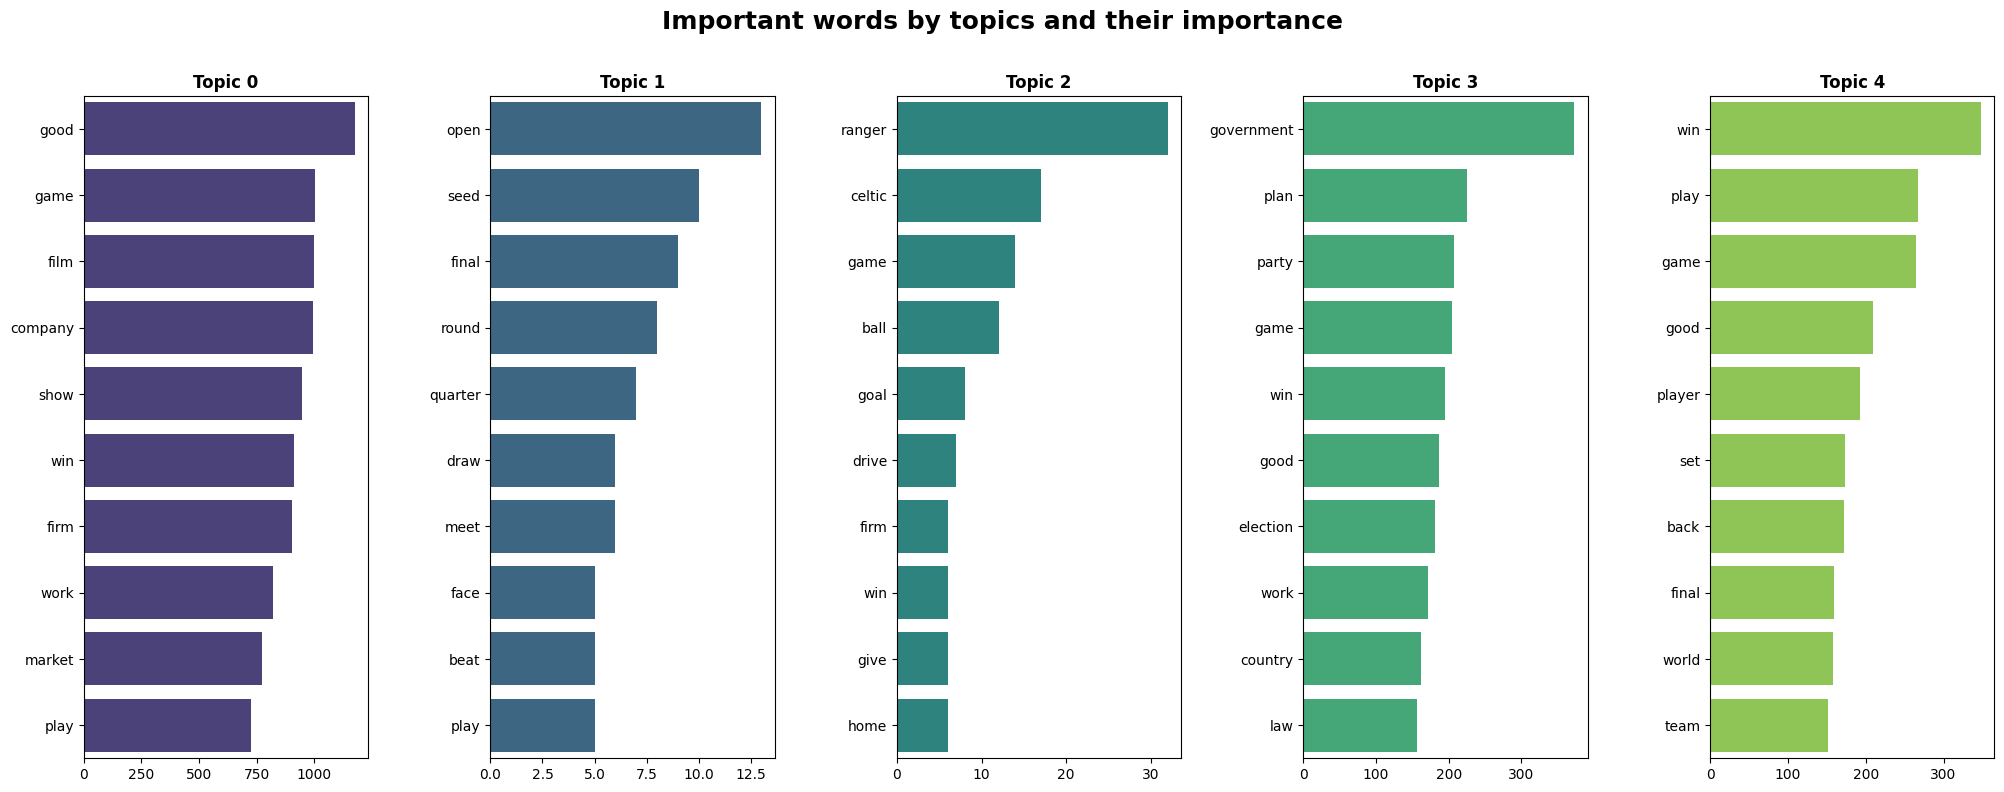

In [56]:
no_top_words = 10
colors = sns.color_palette('viridis', n_colors=len(set(results_df['y_pred'].tolist())))

# Plotting the important words by topics and their importance
fig, ax = plt.subplots(1, len(set(results_df['y_pred'].tolist())), figsize=(20, 8))
fig.suptitle('Important words by topics and their importance', fontsize=18, fontweight='bold')

for i, topic in enumerate(set(results_df['y_pred'].tolist())):
    sorted_words = sorted(words_by_extracted_topics[topic].items(), key=lambda x: x[1], reverse=True)[:no_top_words]
    features = [word[0] for word in sorted_words]
    features_values = [word[1] for word in sorted_words]

    ax[i].set_title(f'Topic {i}', fontsize=12, fontweight='bold')
    sns.barplot(x=features_values, y=features, ax=ax[i], color=colors[i], orient='h')

fig.tight_layout(pad=2.0, rect=[-0.01, -0.02, 1.01, 1])
fig.savefig('../../figures/vontss/important_words_by_topics.png')

# Randomness

In [59]:
n_iter = 5
metrics_df = pd.DataFrame()

for iter in range(n_iter):
    correct_model = False
    while not correct_model:
        topic_model = TopicModel(numb_embeddings=num_topic)
        y_pred, y_pred_probas = topic_model.fit_transform(documents, index=defined_keywords)

        if len(set(list(y_pred_probas.argmax(axis=1)))) == num_topic:
            correct_model = True
        else:
            print(f'[ITER {iter}] Incorrect model, try again')

    model_output = {}
    model_output['topics'] = [i[:topic_model.top_n_words] for i in topic_model.topics]
    model_output['topic-word-matrix'] = topic_model.model.topics.get_topics().cpu().detach().numpy()
    model_output['topic-document-matrix'] = topic_model.z.T

    results_df = pd.DataFrame()
    results_df['document'] = documents
    results_df['y_true'] = documents_df['class_name'].tolist()
    results_df['y_pred'] = y_pred_probas.argmax(axis=1)
    results_df['y_pred_highest_proba'] = y_pred_probas.max(axis=1)

    evaluator = Evaluator(model_output)

    words_by_extracted_topics = get_words_for_topics(results_df['y_pred'].tolist())
    words_by_class = get_words_for_topics(results_df['y_true'].tolist())

    coherence = evaluator.compute_coherence()
    diversity = evaluator.compute_diversity()
    supervised_correlation = evaluator.compute_supervised_correlation(words_by_extracted_topics, words_by_class)

    metrics_df_iter = pd.DataFrame()

    for coherence_type, coherence_value in coherence.items():
        metrics_df_iter[f'Coherence ({coherence_type})'] = [coherence_value]
    metrics_df_iter['Diversity'] = [diversity]
    metrics_df_iter['Supervised correlation'] = [supervised_correlation]

    metrics_df = pd.concat([metrics_df, metrics_df_iter])

metrics_df

[ITER 0] Incorrect model, try again
[ITER 0] Incorrect model, try again
[ITER 0] Incorrect model, try again
[ITER 0] Incorrect model, try again
[ITER 0] Incorrect model, try again
[ITER 0] Incorrect model, try again
[ITER 0] Incorrect model, try again
[ITER 0] Incorrect model, try again
[ITER 2] Incorrect model, try again
[ITER 4] Incorrect model, try again
[ITER 4] Incorrect model, try again
[ITER 4] Incorrect model, try again


,Coherence (c_v),Coherence (c_uci),Coherence (c_npmi),Coherence (u_mass),Diversity,Supervised correlation
0,0.466237,NaN,NaN,NaN,0.96,0.283334
0,0.268242,-5.854221,-0.212343,-3.341028,0.90,0.288093
0,0.278166,-5.626958,-0.206797,-4.033251,0.96,0.229605
0,0.363255,-6.651324,-0.240708,-3.396480,0.96,0.195844
0,0.279124,-4.230112,-0.151013,-3.206223,1.00,0.178919


In [60]:
metrics_df.mean().to_frame().T

,Coherence (c_v),Coherence (c_uci),Coherence (c_npmi),Coherence (u_mass),Diversity,Supervised correlation
0,0.331005,-5.590654,-0.202715,-3.494245,0.956,0.235159


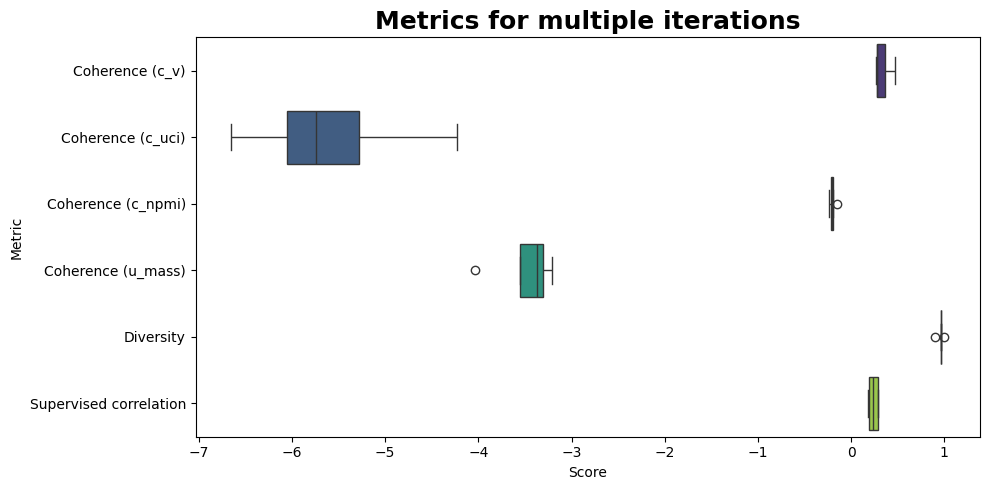

In [61]:
plt.figure(figsize=(10, 5))
plt.title('Metrics for multiple iterations', fontsize=18, fontweight='bold')

sns.boxplot(data=metrics_df, orient='h', palette='viridis')
plt.xlabel('Score')
plt.ylabel('Metric')

plt.tight_layout()
plt.savefig('../../figures/vontss/randomness_boxplot_metrics.png')